In [7]:
import numpy as np
import scipy
from scipy.integrate import dblquad
import matplotlib.pyplot as plt

#### Intro

The coefficent $\eta$ contains a dependence on the structure of the geometry and also the gradient encoding sequence. It is however preferable to obtain a sequence with $T^3$ isotropic.

In [114]:
def make_sin(k):
    return lambda t:np.sin(2*k*np.pi*t)/np.sqrt(2)
def make_cos(k):
    return lambda t:np.cos(2*k*np.pi*t)/np.sqrt(2)

f = []
T = 1
f.append(lambda t: t- T/2)
f.append(lambda t: (t- T/2)**2 - T**2/12)
f.append(lambda t: (t- T/2)*np.abs(t-T/2))
f.append(lambda t: (t- T/2)**3)
f.append(lambda t: np.abs(t- T/2)**3 - T**3/32)
f.append(lambda t: (t- T/2)**4 - T**4/80)
f.append(lambda t: np.abs(t- T/2)*(t- T/2)**3)
f.append(lambda t: (t- T/2)**5)
f.append(lambda t: np.abs(t- T/2)**5 - T**5/192)
# f.append(lambda t: (t- T/2))
# f.append(lambda t: (t- T/2))


N_basis = len(f)

In [115]:
N_basis = 25

f = []
for k in range(0,N_basis):
    k +=1
    f.append(make_sin(k))

# N_basis = 10

# # f = []
# for k in range(0,N_basis):
#     k +=1
#     f.append(make_cos(k))
# N_basis = N_basis*2

In [116]:
m = 3
phi_m =  np.zeros((N_basis,N_basis))
errors = np.zeros((N_basis,N_basis))
for i in range(0,N_basis):
    for j in range(0,i+1):
        int = lambda x,y: f[i](x)*f[j](y)*abs(x-y)**(m/2)
        phi_ij,error = dblquad(int,0,1,0,1, epsabs=1.49e-15, epsrel=1.49e-15)
        phi_m[i,j] = phi_ij
        phi_m[j,i] = phi_ij
        errors[i,j] = error
        errors[j,i] = error
    print(i)
        
        

0
1
2
3
4


c:\Users\amcsween\AppData\Local\miniconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


c:\Users\amcsween\AppData\Local\miniconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


21
22
23
24


In [117]:
X = np.random.normal(size=(3,N_basis))
# X = np.ones((3,N_basis))

In [118]:

def T3(X):
    X = np.reshape(X,(3,N_basis))
    return np.matmul(X,np.matmul(phi_m,X.T))

def seq(X,t):
    y = np.asarray([g(t) for g in f])
    return np.matmul(X,y)
T3(X)

array([[-0.09931399,  0.00746609, -0.08006355],
       [ 0.00746609, -0.00325181,  0.00195187],
       [-0.08006355,  0.00195187, -0.0730787 ]])

In [119]:
def plot(X):
    t = np.linspace(0,1,500)
    g = seq(X,t)
    fig = plt.figure()
    plt.plot(t,g[0,:],label='$g_x$')
    plt.plot(t,g[1,:],label='$g_y$')
    plt.plot(t,g[2,:],label='$g_z$')
    plt.legend()
    plt.show()

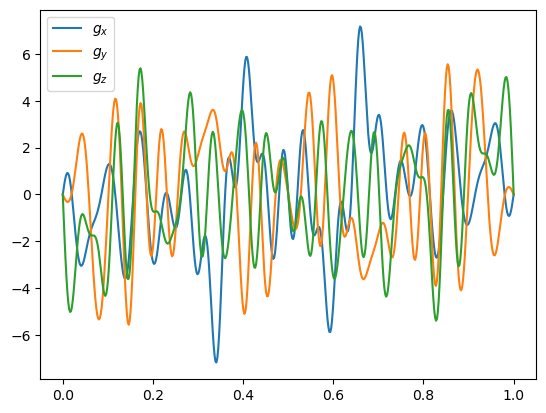

In [120]:
plot(X)

In [121]:
L =5

def fun(X):
    T = T3(X)
    R = T - L*np.eye(3)
    return np.linalg.norm(R)**2


def df_dT(T):
    A = 2*T - L*np.eye(3)
    return A

In [122]:
def dT_dX(X,k,l): 
    a = np.matmul(phi_m,X.T)
    b = np.matmul(X,phi_m)
    B_row = np.reshape(a[:,l] + b[k,:],(1,N_basis))
    B = np.repeat(B_row,3,0)
    return B


In [123]:

def df_dX(X):
    X = X.reshape((3,N_basis))
    T = T3(X)
    df = np.zeros((3,N_basis))
    Bs = np.asarray([[dT_dX(X,k,l) for l in range(0,3)] for k in range(0,3)])
    A = df_dT(T)
    for i in range(0,3):
        for j in range(0,N_basis):
            df[i,j] = np.dot(A.flatten(),Bs[:,:,i,j].flatten())
    return df.flatten()

In [124]:
def get_zero(fun,X0,jac,sigma,gamma,F_tol,X_tol,N_steps = 50):
    X = X0
    noise = np.random.normal(0,sigma,size=(N_steps,len(X)))
    i = 0
    delta_X = 10*X_tol
    res = fun(X)    
    residuals = [res]
    steps = []
    while i < N_steps and res > F_tol:
        dX =-gamma*jac(X)+ noise[i]
        delta_X = np.linalg.norm(dX)
        X +=  dX
        res = fun(X)
        steps.append(delta_X)
        residuals.append(res)
        i+=1
        # print(i)
    return X, residuals,steps
        

In [126]:
X0 = np.ones(3*N_basis)
df = df_dX(X0)
e = 0*X0
h = 1e-15
f0 = fun(X0)
for i in range(0,len(e)):
    e = 0*e
    e[i]=1
    print(np.abs( fun(X0.flatten()+ h*e) - (f0+np.dot(df,h*e)) )/h)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [127]:
T3(X)

array([[-0.09931399,  0.00746609, -0.08006355],
       [ 0.00746609, -0.00325181,  0.00195187],
       [-0.08006355,  0.00195187, -0.0730787 ]])

In [128]:
def F(X):
    X = X.reshape((3,N_basis))
    T = T3(X)
    return T - L*np.eye(3)

def dF(X):
    X = X.reshape((3,N_basis))
    T = T3(X)
    # df = np.zeros((3,N_basis))
    Bs = np.asarray([[dT_dX(X,k,l) for l in range(0,3)] for k in range(0,3)])
    return Bs.reshape((9,3*N_basis))
    # return Bs

In [129]:
N_basis

25

In [151]:
X = np.zeros((3,N_basis))
X[:,0] = 1

In [160]:
# res = scipy.optimize.minimize(fun,X.flatten(),jac=df_dX,method='CG')
# print(res.success)

res = scipy.optimize.least_squares(lambda x: F(x).flatten(),X.flatten(),jac=dF)
print(res.success)





True


In [161]:
res.message

'`ftol` termination condition is satisfied.'

In [162]:
X = res.x.reshape((3,N_basis))

In [163]:
fun(X)

75.00000546601112

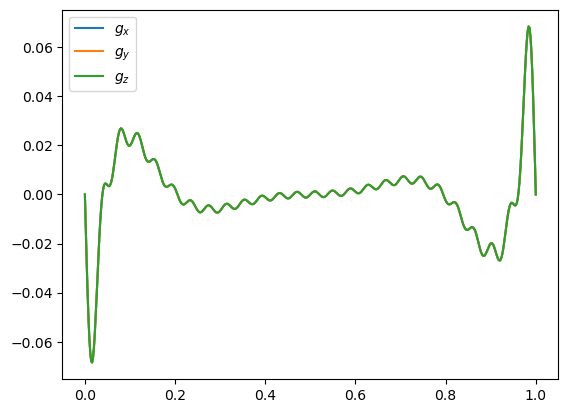

In [164]:
plot(X)

In [165]:
T3(X)

array([[-1.8220036e-07, -1.8220036e-07, -1.8220036e-07],
       [-1.8220036e-07, -1.8220036e-07, -1.8220036e-07],
       [-1.8220036e-07, -1.8220036e-07, -1.8220036e-07]])

In [157]:
fun(X)

75.96265025892

In [158]:
np.linalg.norm(df_dX(X))

2.0435817213740544

In [159]:
N_basis

25